# Basic Hessian AD

For many optimizaton problems, the hessian is useful to speed up convergence or provide approximations through the Taylor expansion. Since the Hessian is sometimes intractible analytically, automatic differentiation is an important and useful tool for getting the Hessian of a function.

In [1]:
!pip3 install git+https://github.com/CS207-Project-Team-1/cs207-FinalProject --ignore-installed

  Cloning https://github.com/CS207-Project-Team-1/cs207-FinalProject to /private/var/folders/jh/ddhjlnr56tn6xz4snpvf4n8r0000gn/T/pip-req-build-ccxjnzur
  Running setup.py bdist_wheel for AutoDiffX ... done
  Stored in directory: /private/var/folders/jh/ddhjlnr56tn6xz4snpvf4n8r0000gn/T/pip-ephem-wheel-cache-qnjbco7h/wheels/59/b4/87/15f5725118c617ef8ac1098e030639efa3347b8d2e954586eb
Successfully built AutoDiffX


In [2]:
from ad import *
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

## Univariate Example

First we start with an easy univariate example, where we know the closed form solution already. Consider the function

$$f(x) = x^2 + \frac{1}{x + 1} - 5x$$

The Hessian in this case is just one variable, which can be analytically solved to be

$$ \frac{d^2}{dx^2} f(x) = \frac{2}{(x+1)^3}+2$$

Let's check whether or not our AD package gives us the correct answer!

In [3]:
x = ad.Variable()
f = x * x + 1 / (x + 1) - 5 * x

x_vals = list(np.linspace(0, 6, 1000))
fx_vals = [f.eval({x: i}) for i in x_vals]
fppx_vals = [f.hessian({x: i}) for i in x_vals]

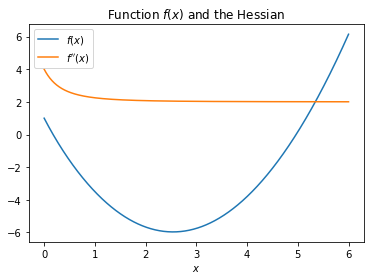

In [4]:
plt.title(r"Function $f(x)$ and the Hessian")
plt.xlabel(r"$x$")
plt.plot(x_vals, fx_vals)
plt.plot(x_vals, fppx_vals)

plt.legend([r'$f(x)$', r"$f''(x)$"])
plt.show()

This matches our analytic form of the Hessian, which is good!

## Multivariate Example

Now let's do a multivariate example. In order to be able to verify our results, we will make a function of two variables so we can easily get the analytical form of the Hessian. However, we can do the exact same thing for more than two variables. Let us consider the Rosenbrock function:

$$f(x, y) = 100(y-x^2)^2 + (1-x)^2 $$

We will demonstrate the benefits of using the Hessian to search for the global minimum of this function by using, and then comparing, steepest descent methods (using just gradient information) with Newton descent methods (involving second derivative information). 

**Steepest Descent**

The steepest descent method works by using the direction of steepest gradient as a search direction, and then moving to a the minimum point of the function being optimised in that direction. This method relies on us knowing first order gradient information on the underlying function.

Our demonstration uses scipy.minimise to carry out a minimisation of the function in the direction taken when the gradient of our objective function is taken at the point being considered. We have plotted contours of the underlying function, as well as the path taken by the solver, to give an idea of the performance of this optimisation method.

In [4]:
#implementation of steepest descent algorithm
#find search direction using gradient function
#find minimum point in that direction, and move there
#repeat the process until global minimum has been found
def steepest_descent(initial_point, f):
    point = initial_point
    delta = np.inf
    tol = 1e-8
    count = 0
    x_points = [initial_point[x]]
    y_points = [initial_point[y]]
    
    def obj_function(n):
        derivative = f.d(point) 
        x_val = point[x] - n*derivative[x]
        y_val = point[y] - n*derivative[y]
        interim_point = {x : x_val, y : y_val}
        val = f.eval(interim_point)
        return val
    
    while delta > tol:
        derivative = f.d(point)
        n = minimize(obj_function, x0 = 0, method='Nelder-Mead', tol=1e-8).x
        new_point_x = point[x] - n*derivative[x]
        new_point_y = point[y] - n*derivative[y]
        delta = np.linalg.norm([new_point_x - point[x], new_point_y - point[y]], 2)
        point = {x : new_point_x, y : new_point_y}
        x_points.append(point[x])
        y_points.append(point[y])
        count += 1
    
    return point, count, x_points, y_points

Starting Point {Var: 2, Var: 1} Iterations: 2543
Starting Point {Var: 0, Var: 1} Iterations: 8994
Starting Point {Var: -1, Var: 1} Iterations: 8905


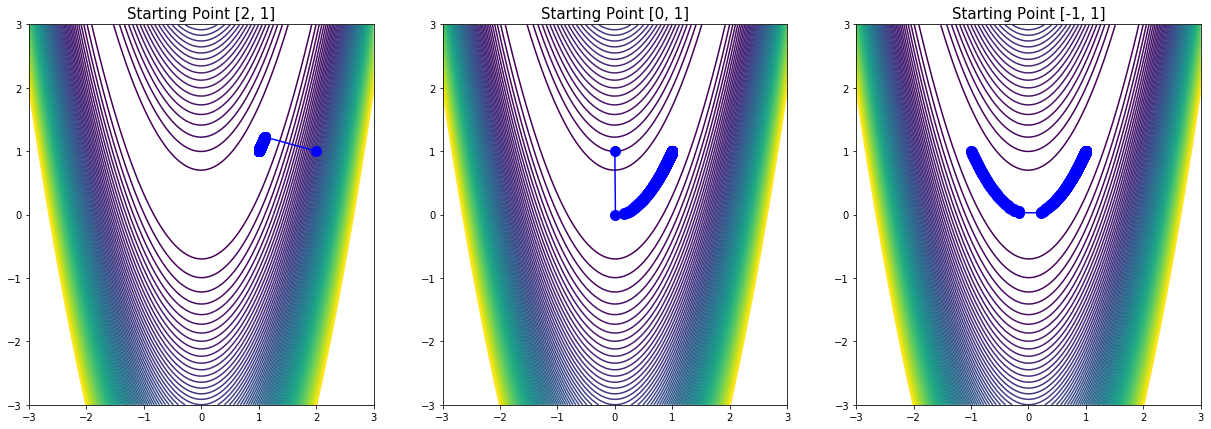

In [5]:
#plot search paths for the three different initial starting points, using Newton method
#very clear that using Hessian information makes searches significantly more effective
#reduces number of iterations by multiple orders of magnitude
x = ad.Variable()
y = ad.Variable()

initial_points = [[2, 1], [0, 1], [-1, 1]]
fig=plt.figure(figsize=(21, 7))
f = 100*(y-x**2)**2 + (1-x)**2

for i, initial_point in enumerate(initial_points):
    first_point = {x : initial_point[0], y : initial_point[1]}
    final_point, iterations, x_points, y_points = steepest_descent(first_point, f)
    print('Starting Point {0} Iterations: {1}'.format(first_point, iterations))
    
    ax = plt.subplot(1, 3, i+1)
    ax = plt.plot(x_points, y_points, 'o-', color = 'b', ms =10)
    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'

    X = np.arange(-3, 3, 0.01)
    Y = np.arange(-3, 3, 0.01)
    X, Y = np.meshgrid(X, Y)
    Z = (np.ones([np.shape(X)[0],np.shape(X)[1]])-X)**2+100*(Y-(X)**2)**2

    levels = np.arange(-2000.0, 5000, 50)
    ax = plt.contour(X, Y, Z, levels=levels)
    ax = plt.xlim(-3, 3)
    ax = plt.ylim(-3, 3)
    ax = plt.title('Starting Point {0}'.format(initial_point), size = 15)

**Newton Method**

The Newton Method uses second derivative information to make finding the minimum more efficient. Assuming point are near a minimum, the second order taylor expansion of the objective function can be solved to give a better location for the function minimum. By iterating through this process, the function minimum can eventually be found. 

Our function used numpy.linalg.solve to solve for the search step between the Hessian and the gradient. We have plotted contours of the underlying function, as well as the path taken by the solver, to give an idea of the performance of this optimisation method. It can be seen that the number of iterations needed was significantly less than for the steepest descent method.

In [6]:
#implementation of Newton method algorithm
def newton_method(initial_point, f):
    point = initial_point
    delta = np.inf
    tol = 1e-8
    count = 0
    x_points = [initial_point[x]]
    y_points = [initial_point[y]]
    Hessian = np.zeros(4).reshape(2,2)
    
    while delta > tol:
        x_val = point[x]
        y_val = point[y]
        derivative = f.d(point)
        hessian = f.hessian(point)
        gradient = np.array([derivative[x], derivative[y]])
        
        Hessian[0][0] = hessian[x][x]
        Hessian[0][1] = hessian[x][y]
        Hessian[1][0] = hessian[y][x]
        Hessian[1][1] = hessian[y][y]
        
        step = np.linalg.solve(Hessian, -gradient)
        delta = np.linalg.norm(step, 2)
        
        x_val += step[0]
        y_val += step[1]
        
        point = {x: x_val, y:y_val}
        count += 1
        x_points.append(point[x])
        y_points.append(point[y])
        
    return point, count, x_points, y_points

Starting Point {Var: 2, Var: 1} Iterations: 6
Starting Point {Var: 0, Var: 1} Iterations: 6
Starting Point {Var: -1, Var: 1} Iterations: 3


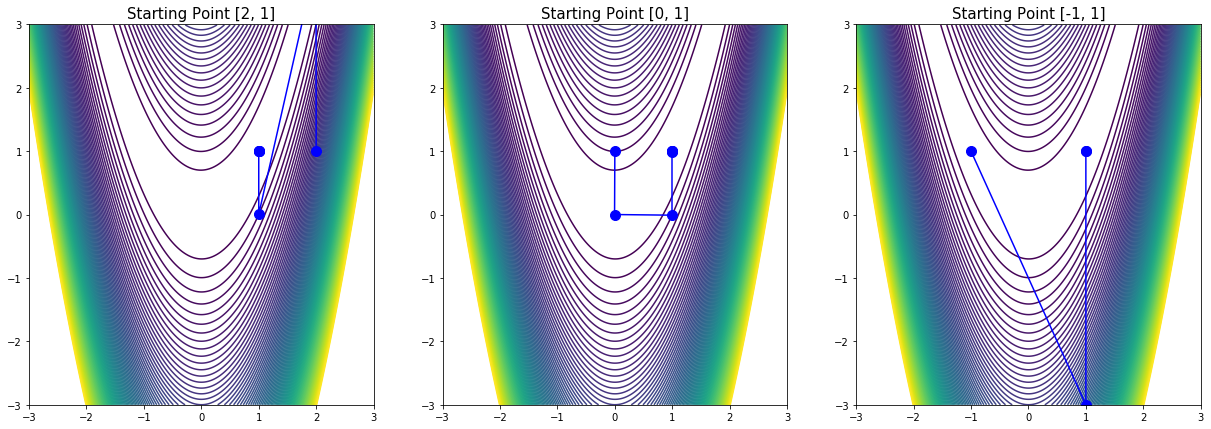

In [7]:
#plot search paths for the three different initial starting points, using Newton method
#very clear that using Hessian information makes searches significantly more effective
#reduces number of iterations by multiple orders of magnitude
x = ad.Variable()
y = ad.Variable()

initial_points = [[2, 1], [0, 1], [-1, 1]]
fig=plt.figure(figsize=(21, 7))
f = 100*(y-x**2)**2 + (1-x)**2

for i, initial_point in enumerate(initial_points):
    first_point = {x : initial_point[0], y : initial_point[1]}
    final_point, iterations, x_points, y_points = newton_method(first_point, f)
    print('Starting Point {0} Iterations: {1}'.format(first_point, iterations))
    ax = plt.subplot(1, 3, i+1)
    ax = plt.plot(x_points, y_points, 'o-', color = 'b', ms =10)
    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'

    X = np.arange(-3, 3, 0.01)
    Y = np.arange(-3, 3, 0.01)
    X, Y = np.meshgrid(X, Y)
    Z = (np.ones([np.shape(X)[0],np.shape(X)[1]])-X)**2+100*(Y-(X)**2)**2

    levels = np.arange(-2000.0, 5000, 50)
    ax = plt.contour(X, Y, Z, levels=levels)
    ax = plt.xlim(-3, 3)
    ax = plt.ylim(-3, 3)
    ax = plt.title('Starting Point {0}'.format(initial_point), size = 15)

**Conclusion**

The table below gives a comparative evaluation of the number of iterations needed to converge to the minimum at (1,1) for the different starting points. It can be seen that including the Hessian caused convergence to speed up by several orders of magnitude.

|  Starting Point 	|   Steepest	|   Newton	|
|---   |---	    |---	|
| 2,1  |  2543	|   6	|
| 0,1  |  8994 	|   6	|
| -1,1 |  8905 	|   3	|

**Higher Order Derivatives**

Our package also gives the ability to calculate higher order derivatives of univariate expressions. There are two ways to do this, using the f.d_n method allows the user to pass in the desired order of differentiation, and the position at which the derivative ought to be evaluated. The f.d_expr method creates a new expression of the desired order, which can then be used and evaluated at any position. Both of these methods are demonstrated below.

In [20]:
#create an expression to test
x = ad.Variable()
f = x**5 + 3*x**2

#evaluate function value and first derivative at x = 1
print('Function Value: ', f.eval({x:1}))
print('First Derivative Value: ', f.d({x:1}))

#evaluate fourth derivative of the function using f.d_n method
print('Fourth Derivative Value: ', f.d_n(n = 4, val = 1))

#evaluate fourth derivative of the function using f.d_expr method
f_fourth_derivative = f.d_expr(4)
print('Fourth Derivative Value: ', f_fourth_derivative.eval({x:1}))

Function Value:  4.0
First Derivative Value:  11.0
Fourth Derivative Value:  120.0
Fourth Derivative Value:  120.0
